In [1]:
import tensorflow as tf

# Check GPU availability
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

GPU is available
TensorFlow version: 2.15.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/New_Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [5]:
def Split_Folders(path):
    train_data_path = path

    filepaths =[]
    labels = []

    folds = os.listdir(train_data_path)

    for fold in folds:
        f_path = os.path.join(train_data_path , fold)
        filelists = os.listdir(f_path)

        for file in filelists:
            filepaths.append(os.path.join(f_path , file))
            labels.append(fold)

    #Concat data paths with labels
    labels = [path.replace('_tumor', '').title() for path in labels]
    Fseries = pd.Series(filepaths , name = 'Path')
    Lseries = pd.Series(labels , name = 'Label')
    New_df = pd.concat([Fseries , Lseries] , axis = 1)
    return New_df , filepaths , labels


In [6]:
Train_path ='/content/New_Dataset/Training'
Test_path = '/content/New_Dataset/Testing'

train_df , train_paths,train_labels = Split_Folders(Train_path)
test_df , test_paths,test_labels = Split_Folders(Test_path)

In [7]:
# 2 values in train_df and 1 in test_df have a un-defined tumor Class
train_df = train_df[train_df['Label'] != 'Tumor']
test_df = test_df[test_df['Label'] != 'Tumor']
#Getting class types
CLASS_TYPES = pd.unique(train_df['Label'])
N_TYPES = len(CLASS_TYPES)
print("Classes =",CLASS_TYPES)

Classes = ['Glioma' 'Normal' 'Pituitary' 'Meningioma']


In [8]:
# Mapping dictionary
Dataset_classes = {'Normal': 0,
                 'Glioma': 1,
                 'Meningioma': 2,
                 'Pituitary': 3
}
# Apply mapping to both DataFrames
train_df['label_encoded'] = train_df['Label'].map(Dataset_classes)
test_df['label_encoded'] = test_df['Label'].map(Dataset_classes)

In [9]:
# Reduced target size and batch size
target_size = (224, 224)
batch_size = 64

# Data Generators for VGG16
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Creating generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=Train_path,
    x_col='Path',
    y_col='Label',
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=Test_path,
    x_col='Path',
    y_col='Label',
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 19788 validated image filenames belonging to 4 classes.
Found 4950 validated image filenames belonging to 4 classes.


In [10]:
# ResNet50 model
resnet_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
resnet_base_model.trainable = False  # You can set it to True if you want to fine-tune the base layers

# Model definition
inputs = resnet_base_model.input
x = GlobalAveragePooling2D()(resnet_base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Adjust dropout rate if necessary
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
resnet_model = Model(inputs=inputs, outputs=outputs)

# Compile the model
from tensorflow.keras.optimizers import Adam
resnet_model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
resnet_model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [11]:
# Callbacks
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=True)
model_cp = ModelCheckpoint('best_weights.h5', save_best_only=True, monitor='val_accuracy')

# Fit the model
history = resnet_model.fit(train_generator, epochs=50, validation_data=test_generator, callbacks=[model_rlr, model_cp])


Epoch 1/50
310/310 [==============================] - ETA: 0s - loss: 0.7800 - accuracy: 0.6881

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


310/310 [==============================] - 117s 340ms/step - loss: 0.7800 - accuracy: 0.6881 - val_loss: 0.4396 - val_accuracy: 0.8378 - lr: 1.0000e-04
Epoch 2/50
310/310 [==============================] - 99s 318ms/step - loss: 0.4611 - accuracy: 0.8222 - val_loss: 0.3417 - val_accuracy: 0.8703 - lr: 1.0000e-04
Epoch 3/50
310/310 [==============================] - 100s 321ms/step - loss: 0.3656 - accuracy: 0.8601 - val_loss: 0.2967 - val_accuracy: 0.8901 - lr: 1.0000e-04
Epoch 4/50
310/310 [==============================] - 99s 319ms/step - loss: 0.3046 - accuracy: 0.8859 - val_loss: 0.2539 - val_accuracy: 0.9059 - lr: 1.0000e-04
Epoch 5/50
310/310 [==============================] - 99s 320ms/step - loss: 0.2620 - accuracy: 0.8999 - val_loss: 0.2162 - val_accuracy: 0.9147 - lr: 1.0000e-04
Epoch 6/50
310/310 [==============================] - 98s 317ms/step - loss: 0.2306 - accuracy: 0.9139 - val_loss: 0.2014 - val_accuracy: 0.9273 - lr: 1.0000e-04
Epoch 7/50
310/310 [=================

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

# Function to generate a confusion matrix and classification report
def generate_confusion_matrix(model, generator, steps, class_names):
    # Initialize lists to hold true and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate over the data in the generator
    for _, batch in zip(range(steps), generator):
        images, labels = batch
        predictions = model.predict(images, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels, axis=1)

        true_labels.extend(true_classes)
        predicted_labels.extend(predicted_classes)

    # Calculate confusion matrix and classification report
    cm = confusion_matrix(true_labels, predicted_labels)
    class_report = classification_report(true_labels, predicted_labels, target_names=class_names)

    print("Classification Report:\n", class_report)
    return cm

# Determine steps per epoch for test set
steps_per_epoch_test = int(np.ceil(test_generator.samples / test_generator.batch_size))

# Call the function after model training to evaluate on test set
cm = generate_confusion_matrix(resnet_model, test_generator, steps_per_epoch_test, class_names=CLASS_TYPES)

Classification Report:
               precision    recall  f1-score   support

      Glioma       0.98      0.95      0.96      1262
      Normal       0.95      0.97      0.96      1279
   Pituitary       0.99      1.00      0.99      1227
  Meningioma       0.98      0.99      0.99      1182

    accuracy                           0.97      4950
   macro avg       0.98      0.98      0.98      4950
weighted avg       0.97      0.97      0.97      4950



In [13]:
import seaborn as sns

In [14]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(9, 9))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

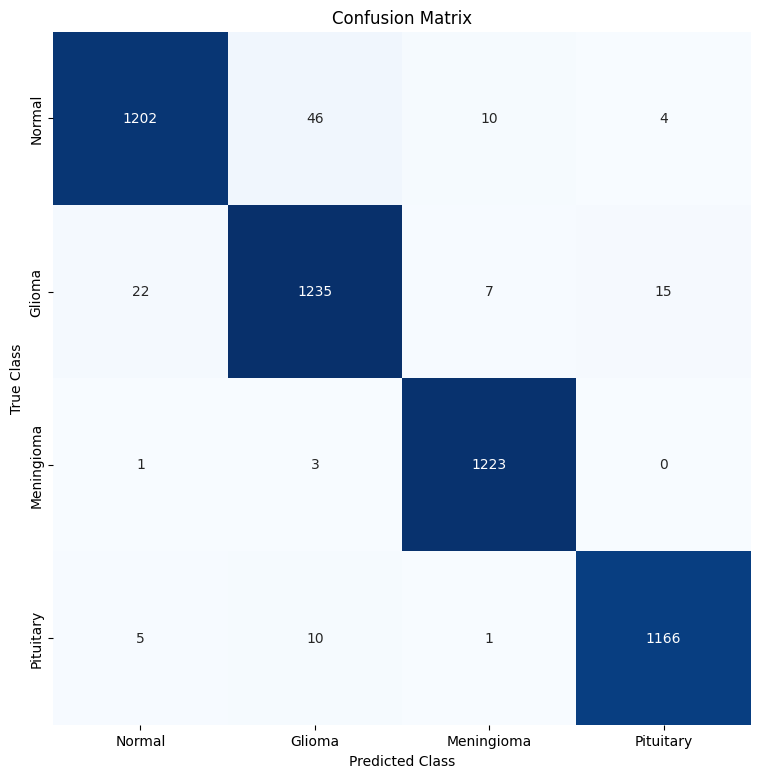

In [15]:
plot_confusion_matrix(cm,Dataset_classes.keys())

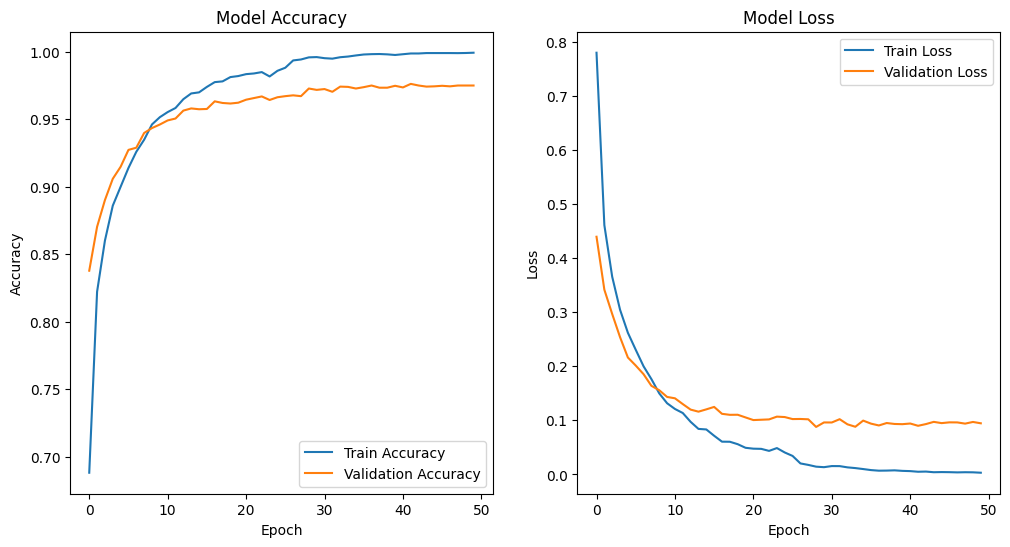

In [16]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.show()